<a href="https://colab.research.google.com/github/Rakshan404/Quantum_Option_Pricing/blob/main/Quantum_Option_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parameters Loaded ✓
Distribution Discretized ✓


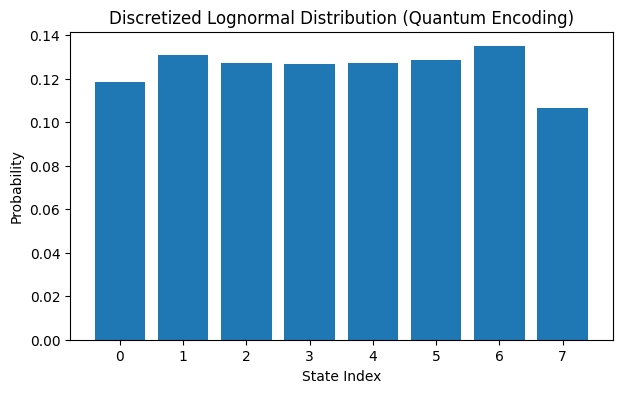


📌 Classical Expected Payoff: 16.81112693073118
📌 Classical Option Price: 16.643853422906567
Quantum Circuit Constructed ✓

🎯 FINAL RESULTS
📌 Classical price: 16.643853422906567
📌 Quantum estimated price: 16.34974842867031
📌 Difference: 0.2941049942362568


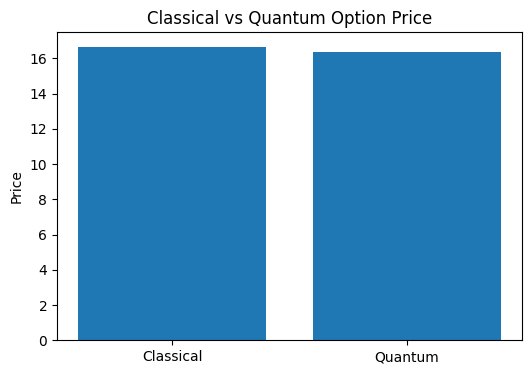

In [7]:

import numpy as np
from scipy.special import erfinv
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import Initialize
from qiskit_aer import AerSimulator
from math import erf, sqrt

# The initial stock price can be changed according to the user

S0 = 100.0         # initial stock price
K = 100.0          # strike price
r = 0.01           # risk-free rate
T = 1.0            # 1 year maturity
sigma = 0.5        # volatility
n_qubits = 3       # number of qubits representing distribution
shots = 5000       # simulator samples

print("Parameters Loaded ✓")

num_states = 2**n_qubits
ps = np.linspace(0.5/num_states, 1 - 0.5/num_states, num_states)

mu = np.log(S0) + (r - 0.5*sigma**2)*T
sd = sigma * np.sqrt(T)

# Inverse CDF via SciPy's erfinv (NumPy 2.x fix)
S_T_vals = np.exp(mu + sd * np.sqrt(2) * erfinv(2*ps - 1))

# Compute PDF bins (probabilities)
def lognormal_cdf(x):
    if x <= 0:
        return 0.0
    z = (np.log(x) - mu) / sd
    return 0.5 * (1 + erf(z / sqrt(2)))

edges = np.concatenate(([0], (S_T_vals[:-1] + S_T_vals[1:]) / 2, [S_T_vals[-1] * 2]))

probs = np.array([lognormal_cdf(edges[i+1]) - lognormal_cdf(edges[i]) for i in range(num_states)])
probs = probs / probs.sum()

print("Distribution Discretized ✓")

# Plot distribution
plt.figure(figsize=(7,4))
plt.bar(range(num_states), probs)
plt.title("Discretized Lognormal Distribution (Quantum Encoding)")
plt.xlabel("State Index")
plt.ylabel("Probability")
plt.show()

payoffs = np.maximum(S_T_vals - K, 0)
expected_payoff_classical = np.dot(probs, payoffs)
classical_price = np.exp(-r*T) * expected_payoff_classical

print("\n📌 Classical Expected Payoff:", expected_payoff_classical)
print("📌 Classical Option Price:", classical_price)

amps = np.sqrt(probs)
amps = amps / np.linalg.norm(amps)

init = Initialize(amps)

qc = QuantumCircuit(n_qubits + 1, 1)
qc.append(init, range(n_qubits))

max_payoff = payoffs.max()

for idx in range(num_states):
    payoff = payoffs[idx]
    payoff_norm = payoff / max_payoff if max_payoff > 0 else 0

    # FIX: clamp floating noise
    payoff_norm = min(max(payoff_norm, 0), 1)

    theta = 2 * np.arcsin(np.sqrt(payoff_norm))

    if theta == 0 or np.isnan(theta):
        continue

    basis = format(idx, '0{}b'.format(n_qubits))

    # Match basis pattern using X gates
    for q, bit in enumerate(reversed(basis)):
        if bit == '0':
            qc.x(q)

    # Multi-controlled rotation
    qc.mcry(theta, list(range(n_qubits)), n_qubits)

    # Undo flips
    for q, bit in enumerate(reversed(basis)):
        if bit == '0':
            qc.x(q)

qc.measure(n_qubits, 0)

print("Quantum Circuit Constructed ✓")

backend = AerSimulator()
job = backend.run(qc, shots=shots)
counts = job.result().get_counts()

p1 = counts.get("1", 0) / shots
expected_payoff_quantum = p1 * max_payoff
quantum_price = np.exp(-r*T) * expected_payoff_quantum

print("\n🎯 FINAL RESULTS")
print("📌 Classical price:", classical_price)
print("📌 Quantum estimated price:", quantum_price)
print("📌 Difference:", abs(quantum_price - classical_price))

# Plot comparison
plt.figure(figsize=(6,4))
plt.bar(["Classical", "Quantum"], [classical_price, quantum_price])
plt.title("Classical vs Quantum Option Price")
plt.ylabel("Price")
plt.show()
